# Import packages

In [1]:
import pandas as pd
import json
import os
import numpy as np
import yaml
from tqdm import tqdm

from datetime import datetime
from scipy.stats import beta, binom
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import fmin
from cycler import cycler

# Setup

In [2]:
# This command reloads our modules as we edit them
%load_ext autoreload
%autoreload 2

# Add our source folder to the path
import sys
sys.path.append("../src/")

# Useful to have logging shown here
import logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)

## Matplotlib

In [3]:
black = (23 / 256, 25 / 256, 22 / 256)
navy = (56 / 256, 74 / 256, 143 / 256)
teal = (106 / 256, 197 / 256, 179 / 256)
pink = [199 / 255, 99 / 255, 150 / 255]

mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'grey'

mpl.rcParams['lines.linewidth'] = 3

mpl.rcParams['legend.frameon'] = False

mpl.rcParams['xtick.color'] = 'grey'
mpl.rcParams['ytick.color'] = 'grey'
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 0
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 0


mpl.rcParams['axes.labelcolor'] = 'grey'

mpl.rcParams['figure.figsize'] = (10, 7)

mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 500
mpl.rcParams['savefig.transparent'] = True

mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.prop_cycle'] = cycler(color=[teal, navy, pink])


## Import Code

In [4]:
from simulation_methods import calculate_audience, get_initial_guess
from loss_calculation_functions import calculate_loss

# Monte Carlo

In [5]:
conversion_rate_pc = 5
uplift_samples = norm.rvs(loc = 0, scale = 2.5, size=1000)

audience_for_stat_sig_samples = []
audience_for_loss_samples = []
loss_at_stat_sig_samples = []
loss_at_loss_samples = []

with tqdm(total=len(uplift_samples)) as progress:
    for uplift in uplift_samples:
        
        initial_guess = 1000
        warnflag = 1
        while warnflag != 0 and initial_guess <= 10_000_000:
            xmin, warnflag = calculate_audience(get_initial_guess(uplift), conversion_rate_pc, uplift)
            initial_guess *= 10

        audience_for_stat_sig = xmin
        audience_for_loss = np.int64(audience_for_stat_sig / 2)

        audience_for_stat_sig_samples.append(audience_for_stat_sig)
        audience_for_loss_samples.append(audience_for_loss)

        loss_at_stat_sig_samples.append(
            calculate_loss(
                100 * binom.rvs(audience_for_stat_sig, conversion_rate_pc / 100) / audience_for_stat_sig, 
                100 * (100 * binom.rvs(audience_for_stat_sig, conversion_rate_pc / 100 * (1 + uplift / 100)) / audience_for_stat_sig - conversion_rate_pc) / conversion_rate_pc, 
                audience_for_stat_sig)
        )
        loss_at_loss_samples.append(
            calculate_loss(
                100 * binom.rvs(audience_for_loss, conversion_rate_pc / 100) / audience_for_loss,
                100 * (100 * binom.rvs(audience_for_loss, conversion_rate_pc / 100 * (1 + uplift / 100)) / audience_for_loss - conversion_rate_pc) / conversion_rate_pc,
                audience_for_loss)
        )

        progress.update(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:24<00:00,  3.08it/s]


In [6]:
from scipy.stats import binom
binom.rvs(10000, 0.1)

998

## Plots

Text(10, 25, 'Negative Uplift')

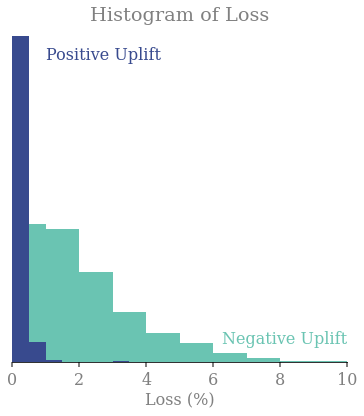

In [7]:
f, ax = plt.subplots(figsize=(6, 6))

ax.hist(
    [
        loss for i, loss in enumerate(loss_at_stat_sig_samples) 
        if uplift_samples[i] < 0
    ], 
    alpha = 1,
    bins=np.linspace(0, 10, 11),
    color=teal
)

ax.hist(
    [
        loss for i, loss in enumerate(loss_at_stat_sig_samples) 
        if uplift_samples[i] > 0
    ], 
    alpha = 1,
    bins=np.linspace(0, 10, 21),
    color=navy
)


ax.set_xlim(0, 10)
ax.set_ylim(0, 350)
ax.set_yticks([])
ax.set_xlabel('Loss (%)')
# ax.set_title('Negative Experiments', y=1.03)
# ax.legend(labels=['Negative Uplift', 'Positive Uplift'], loc=1)
ax.set_title("Histogram of Loss", y=1.03)
ax.text(x=1, y=330, s='Positive Uplift', verticalalignment='center', horizontalalignment='left', color=navy)
ax.text(x=10, y=25, s='Negative Uplift', verticalalignment='center', horizontalalignment='right', color=teal)

# f.savefig('../figures/loss_histogram.png')

Text(0.5, 0, 'Loss at end of experiment (%)')

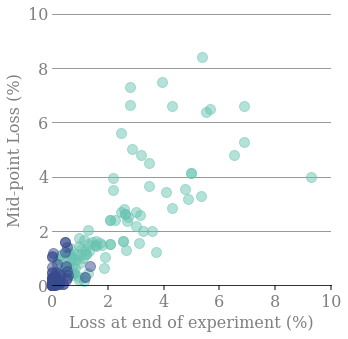

In [8]:
f, ax = plt.subplots(figsize=(5, 5))

_100_neg_indices = np.random.choice(range(sum(uplift_samples < 0)), size=100)
ax.plot(
    np.array([
        loss for i, loss in enumerate(loss_at_stat_sig_samples) 
        if uplift_samples[i] < 0
    ])[_100_neg_indices], 
    np.array([
        loss for i, loss in enumerate(loss_at_loss_samples) 
        if uplift_samples[i] < 0
    ])[_100_neg_indices], 
    '.',
    color=teal,
    markersize=20,
    alpha=0.5, 
    clip_on=False
)

_100_pos_indices = np.random.choice(range(sum(uplift_samples > 0)), size=100)
ax.plot(
    np.array([
        loss for i, loss in enumerate(loss_at_stat_sig_samples) 
        if uplift_samples[i] > 0
    ])[_100_pos_indices], 
    np.array([
        loss for i, loss in enumerate(loss_at_loss_samples) 
        if uplift_samples[i] > 0
    ])[_100_pos_indices], 
    '.',
    color=navy,
    markersize=20,
    alpha=0.5, 
    clip_on=False
)

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_ylabel('Mid-point Loss (%)')
ax.set_xlabel('Loss at end of experiment (%)')

# f.savefig('../figures/loss_scatter.png')

# Loss vs Statistical Significance

In [9]:
from loss_vs_stat_sig_functions import *

In [10]:
def generate_precision_recall_plot(
    loss_at_stat_sig_samples,
    uplift_go_or_nogo_samples,
    uplift_samples,
    plot_uplift=False
):
    threshold_values = np.linspace(0, 5, 101)
    precision = []
    recall = []
    uplift = []
    for threshold_loss in threshold_values:
        threshold_loss_go_or_nogo_samples = is_go_or_nogo_loss(loss_at_stat_sig_samples, threshold_loss)
        precision.append(
            calculate_precision(threshold_loss_go_or_nogo_samples, uplift_go_or_nogo_samples))
        recall.append(
            calculate_recall(threshold_loss_go_or_nogo_samples, uplift_go_or_nogo_samples))
        uplift.append(
            calculate_total_uplift(threshold_loss_go_or_nogo_samples, uplift_samples))
        
    f, ax = plt.subplots(figsize=(10, 5))
    uplift_ss = calculate_total_uplift(uplift_go_or_nogo_samples, uplift_samples)
    uplift_ratio = np.array(uplift) / uplift_ss

    ax.plot(threshold_values, precision, color=teal, linewidth=5)
    ax.plot(threshold_values, recall, color=navy, linewidth=5)

    if plot_uplift:
        ax.plot(threshold_values, uplift_ratio, '--', color=pink, linewidth=5)
    ax.set_ylim(0, 1.01)
    
    ax.set_xlabel(r"Threshold Loss")
    
    if plot_uplift:
        ax.text(x=threshold_values[-1], y=uplift_ratio[-1] - 0.025, s='Uplift Ratio', 
            horizontalalignment='right', verticalalignment='top', 
            color=pink)
#     else:
    ax.text(x=threshold_values[-1], y=precision[-1] - 0.025, s='Precision', 
            horizontalalignment='right', verticalalignment='top', 
            color=teal)
    ax.text(x=threshold_values[-1], y=recall[-1] - 0.025, s='Recall', 
            horizontalalignment='right', verticalalignment='top', 
            color=navy)
    
    
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_yticklabels([f"{s}%" for s in range(0, 101, 20)])
    
    args = (threshold_values, uplift_ratio)
    return f, ax, args

In [11]:
uplift_go_or_nogo_samples = uplift_samples > 0

/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


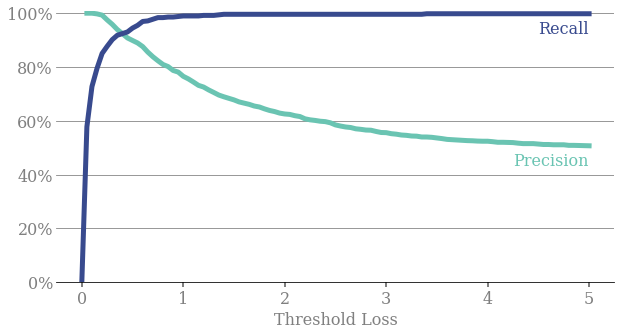

In [12]:
f, ax, args = generate_precision_recall_plot(
    loss_at_stat_sig_samples,
    uplift_go_or_nogo_samples,
    uplift_samples#,
#     plot_uplift=True
)

# f.savefig('../figures/precision_recall.png')

## Loss at half audience

/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


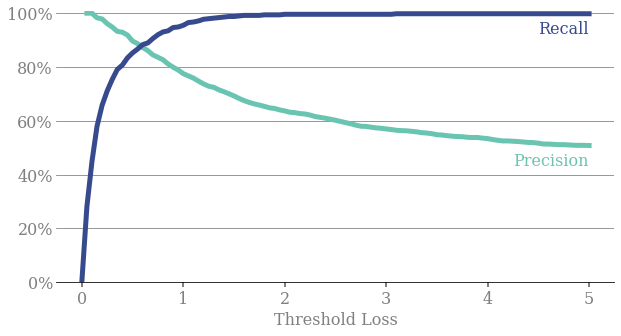

In [13]:
f, ax, args = generate_precision_recall_plot(
    loss_at_loss_samples,
    uplift_go_or_nogo_samples,
    uplift_samples#,
    #plot_uplift=True
)

# f.savefig('../figures/precision_recall_midpoint.png')

/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


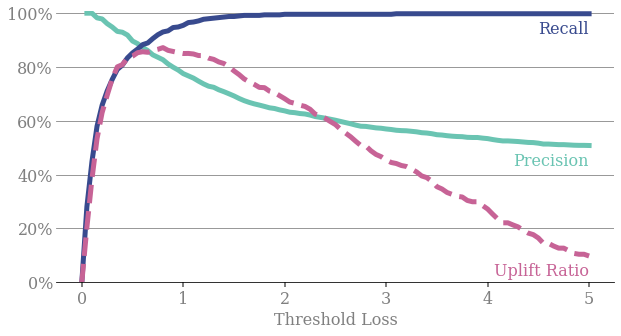

In [14]:
f, ax, args = generate_precision_recall_plot(
    loss_at_loss_samples,
    uplift_go_or_nogo_samples,
    uplift_samples,
    plot_uplift=True
)

# f.savefig('../figures/precision_recall_midpoint_upliftratio.png')